# Annoting the Dataset

In [ ]:
# Annoting the dataset
import os
import json
from PIL import Image
from google.colab import drive

drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/image_chips_native"
output_json = "/content/drive/MyDrive/solar_panel_coco_annotations.json"

# Label folders
labels_hd_path = os.path.join(dataset_path, "labels_hd")
labels_native_path = os.path.join(dataset_path, "labels_native")

# Initialize COCO components
images_coco = []
annotations_coco = []
categories_coco = []

# We have one category: "solar_panel"
category_id = 1
categories_coco.append({
    "id": category_id,
    "name": "solar_panel",
    "supercategory": "none"
})

image_id = 1
annotation_id = 1

# Defining valid image extensions
valid_extensions = (".jpg", ".jpeg", ".png", ".tif", ".tiff")

# Walk through the dataset folder
for root, dirs, files in os.walk(dataset_path):
    for filename in files:
        if filename.lower().endswith(valid_extensions):
            image_path = os.path.join(root, filename)
            try:
                img = Image.open(image_path)
            except Exception as e:
                print(f"Error opening image {filename}: {e}")
                continue

            # Adding image metadata to COCO structure.
            # We store the file name relative to the dataset_path.
            images_coco.append({
                "id": image_id,
                "file_name": os.path.relpath(image_path, dataset_path),
                "width": img.width,
                "height": img.height
            })

            # Determining chip resolution based on image dimensions.
            if img.width == 416 and img.height == 416:
                chip_width = 416
                chip_height = 416
            elif img.width == 832 and img.height == 832:
                chip_width = 832
                chip_height = 832
            else:
                chip_width = img.width
                chip_height = img.height

            # Constructing expected label filename
            base_name = os.path.splitext(filename)[0]
            label_filename = base_name + ".txt"

            # Check for label file in both labels_native and labels_hd directories.
            label_file = None
            possible_native = os.path.join(labels_native_path, label_filename)
            possible_hd = os.path.join(labels_hd_path, label_filename)
            if os.path.exists(possible_native):
                label_file = possible_native
            elif os.path.exists(possible_hd):
                label_file = possible_hd
            else:
                print(f"No label file found for image: {filename}")
                continue

            # If a label file exists, parse its contents.
            if label_file:
                with open(label_file, 'r') as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        parts = line.split()
                        if len(parts) != 5:
                            print(f"Skipping line (unexpected format) in {label_file}: {line}")
                            continue
                        try:
                            obj_category = int(parts[0])
                            x_center_norm = float(parts[1])
                            y_center_norm = float(parts[2])
                            width_norm = float(parts[3])
                            height_norm = float(parts[4])
                        except Exception as e:
                            print(f"Error parsing line in {label_file}: {line}. Error: {e}")
                            continue

                        # Converting normalized coordinates to absolute pixel coordinates.
                        abs_x_center = x_center_norm * chip_width
                        abs_y_center = y_center_norm * chip_height
                        abs_width = width_norm * chip_width
                        abs_height = height_norm * chip_height

                        # Ensuring bounding box coordinates are within the image dimensions
                        x_min = max(0, abs_x_center - abs_width / 2)
                        y_min = max(0, abs_y_center - abs_height / 2)
                        x_max = min(chip_width, x_min + abs_width)
                        y_max = min(chip_height, y_min + abs_height)

                        # Creating the annotation in COCO format.
                        annotations_coco.append({
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": category_id,
                            "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                            "area": (x_max - x_min) * (y_max - y_min),
                            "iscrowd": 0
                        })
                        annotation_id += 1

            image_id += 1

# Building final COCO JSON structure.
coco_format = {
    "images": images_coco,
    "annotations": annotations_coco,
    "categories": categories_coco
}

# Save the annotation file.
with open(output_json, 'w') as f:
    json.dump(coco_format, f, indent=4)

print(f"COCO annotation file saved: {output_json}")
print(f"Total images processed: {len(images_coco)}")
print(f"Total annotations processed: {len(annotations_coco)}")


# Statistical Analysis

In [ ]:
# Dataset Statistics
import json
from collections import defaultdict

# Loading COCO annotations
with open('/content/drive/MyDrive/image_chips_native/solar_panel_coco_annotations.json', 'r') as f:
    coco_data = json.load(f)

annotations = coco_data['annotations']
images = coco_data['images']

# Total solar panel instances
total_instances = len(annotations)
print(f"Total solar panel instances: {total_instances}")

# Labels per image
image_ann_counts = defaultdict(int)
for ann in annotations:
    image_id = ann['image_id']
    image_ann_counts[image_id] += 1

# Counting images with 0,1,... labels
count_distribution = defaultdict(int)
for img in images:
    img_id = img['id']
    count = image_ann_counts.get(img_id, 0)
    count_distribution[count] += 1

print("Labels per image distribution:")
for count in sorted(count_distribution.keys()):
    print(f"{count_distribution[count]} images have {count} labels")

Total solar panel instances: 29625
Labels per image distribution:
81 images have 1 labels
168 images have 2 labels
224 images have 3 labels
219 images have 4 labels
218 images have 5 labels
189 images have 6 labels
171 images have 7 labels
184 images have 8 labels
170 images have 9 labels
121 images have 10 labels
99 images have 11 labels
84 images have 12 labels
70 images have 13 labels
49 images have 14 labels
47 images have 15 labels
41 images have 16 labels
36 images have 17 labels
25 images have 18 labels
29 images have 19 labels
14 images have 20 labels
4 images have 21 labels
1 images have 22 labels
4 images have 23 labels
2 images have 24 labels
4 images have 25 labels
3 images have 26 labels
5 images have 27 labels
5 images have 28 labels
15 images have 29 labels
21 images have 30 labels
8 images have 31 labels
8 images have 32 labels
13 images have 33 labels
19 images have 34 labels
10 images have 35 labels
6 images have 36 labels
18 images have 37 labels
13 images have 38 la

Total solar panel instances: 29625


<ipython-input-3-cf58c32d3c97>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_per_image, y=num_images_with_labels, palette='Blues_d')


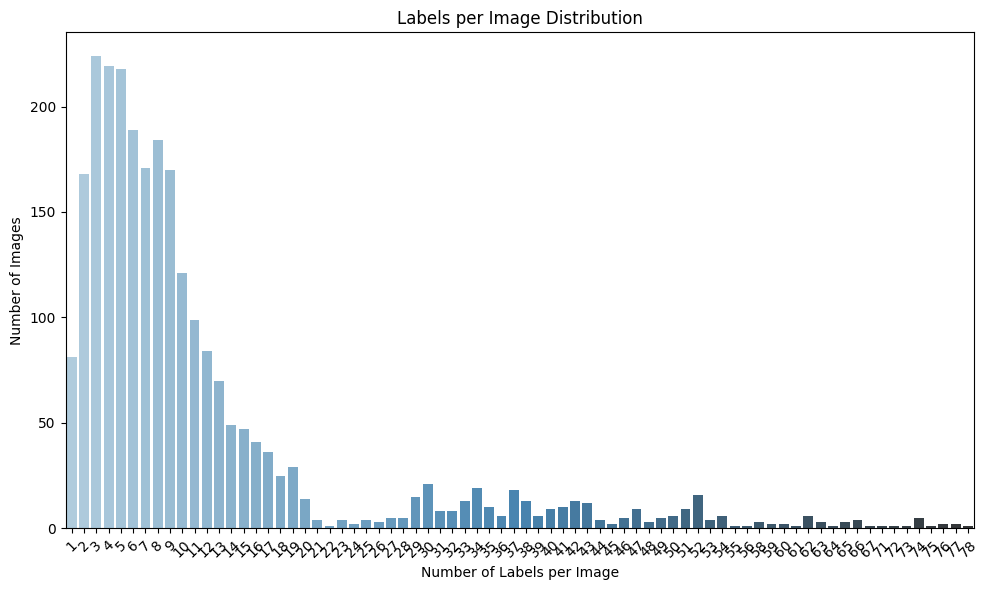

Total Solar Panel Instances: 29625


<ipython-input-3-cf58c32d3c97>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=counts, palette='viridis')


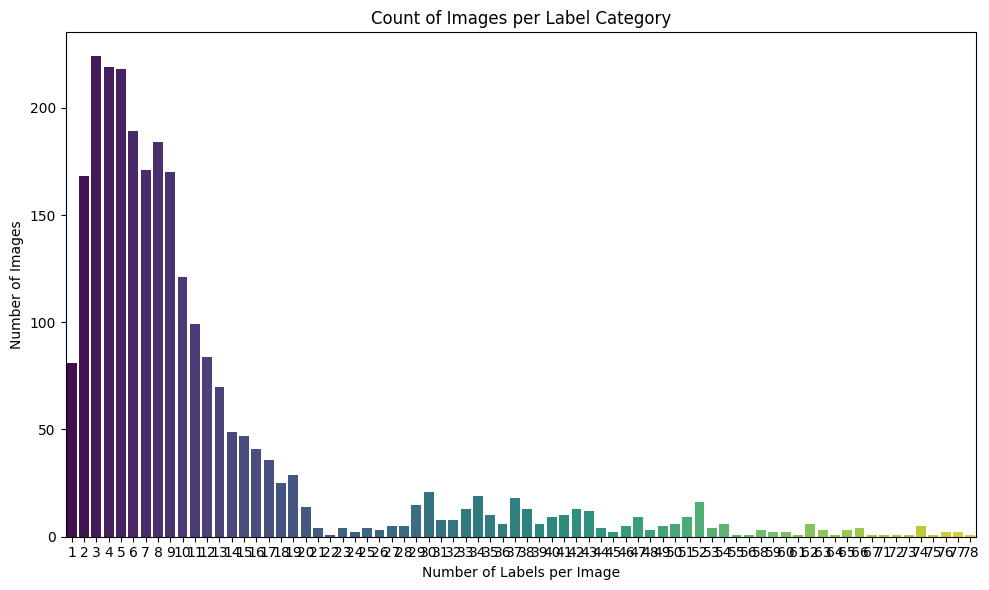

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Total solar panel instances
total_instances = len(annotations)
print(f"Total solar panel instances: {total_instances}")

# Labels per image
image_ann_counts = defaultdict(int)
for ann in annotations:
    image_id = ann['image_id']
    image_ann_counts[image_id] += 1

# Count images with 0,1,... labels
count_distribution = defaultdict(int)
for img in images:
    img_id = img['id']
    count = image_ann_counts.get(img_id, 0)
    count_distribution[count] += 1

# Visualization 1: Labels per Image Distribution
labels_per_image = list(count_distribution.keys())
num_images_with_labels = list(count_distribution.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=labels_per_image, y=num_images_with_labels, palette='Blues_d')
plt.title('Labels per Image Distribution')
plt.xlabel('Number of Labels per Image')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 2: Total Solar Panel Instances (a simple display)
print(f"Total Solar Panel Instances: {total_instances}")

# Optional: Visualization 3 - Count of Instances per Label Category
# Visualize how many images have 0, 1, 2, etc. annotations.
count_distribution_items = list(count_distribution.items())
count_distribution_items.sort()

categories = [str(item[0]) for item in count_distribution_items]
counts = [item[1] for item in count_distribution_items]

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=counts, palette='viridis')
plt.title('Count of Images per Label Category')
plt.xlabel('Number of Labels per Image')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

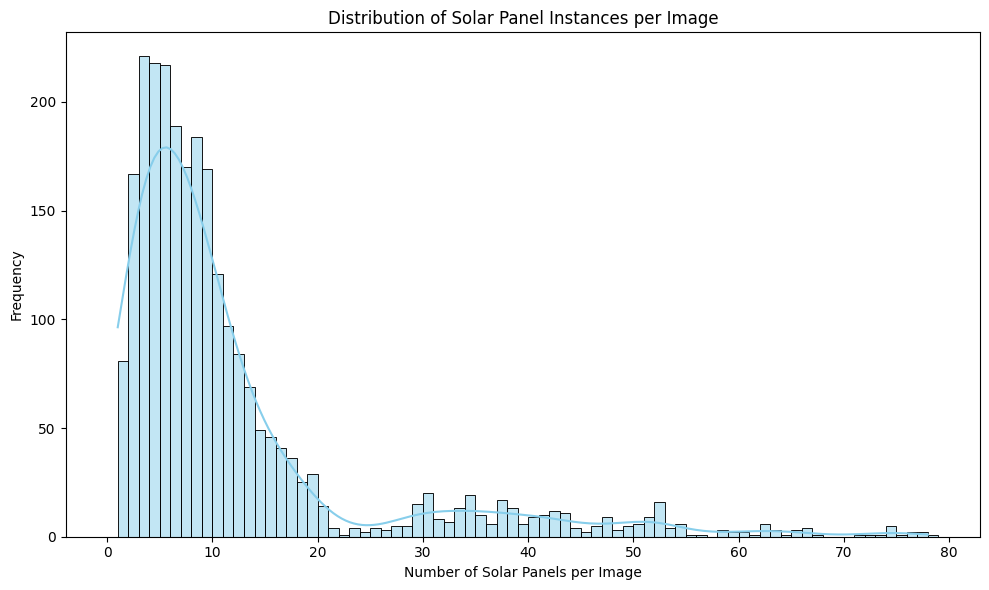

In [ ]:
# Counting the number of solar panel instances per image
num_labels_per_image = list(image_ann_counts.values())

# Visualization of the distribution of solar panel instances per image
plt.figure(figsize=(10, 6))
sns.histplot(num_labels_per_image, bins=range(0, max(num_labels_per_image) + 2), kde=True, color='skyblue')
plt.title('Distribution of Solar Panel Instances per Image')
plt.xlabel('Number of Solar Panels per Image')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
# Calculating the average number of labels per image
avg_labels_per_image = np.mean(num_labels_per_image)
print(f"Average number of labels per image: {avg_labels_per_image:.2f}")


Average number of labels per image: 11.65


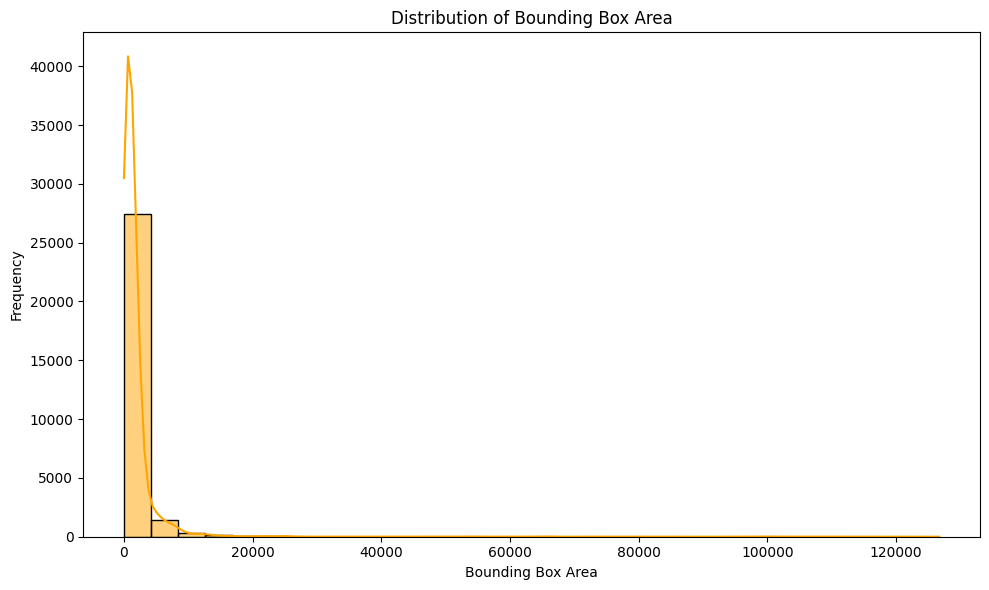

In [ ]:
def calculate_area(bbox):
    x, y, w, h = bbox
    return w * h

# Extracting bounding box coordinates
bbox_areas = [calculate_area(ann['bbox']) for ann in annotations]

# Visualization of bounding box areas
plt.figure(figsize=(10, 6))
sns.histplot(bbox_areas, bins=30, kde=True, color='orange')
plt.title('Distribution of Bounding Box Area')
plt.xlabel('Bounding Box Area')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# Calculating the Area

In [ ]:
image_sizes = [(img['width'], img['height']) for img in images]

import pandas as pd

df = pd.DataFrame({
    'image_size': [w * h for w, h in image_sizes],
    'label_count': [image_ann_counts.get(img['id'], 0) for img in images]
})

# Calculating correlation
correlation = df.corr()
print(f"Correlation between image size and label count: {correlation.iloc[0, 1]:.2f}")


Correlation between image size and label count: nan


In [ ]:
# For native resolution
pixel_to_meter_native = 0.31  # 31 cm per pixel

# Function to calculate the area for native resolution
def calculate_area_m2_native(bbox, scale_factor):
    x, y, w, h = bbox
    area_pixels = w * h
    area_m2 = area_pixels * (scale_factor ** 2)  # Convert pixel area to m²
    return area_m2

# Example usage for native resolution
bbox_areas_native = [calculate_area_m2_native(ann['bbox'], pixel_to_meter_native) for ann in annotations]
mean_area_native = np.mean(bbox_areas_native)
std_area_native = np.std(bbox_areas_native)

print(f"Mean Area (Native Resolution) in m²: {mean_area_native:.6f}")
print(f"Standard Deviation (Native Resolution) in m²: {std_area_native:.6f}")


Mean Area (Native Resolution) in m²: 191.517828
Standard Deviation (Native Resolution) in m²: 630.700336


In [ ]:
# For HD resolution
pixel_to_meter_hd = 0.155  # 15.5 cm per pixel

# Function to calculate the area for HD resolution
def calculate_area_m2_hd(bbox, scale_factor):
    x, y, w, h = bbox
    area_pixels = w * h
    area_m2 = area_pixels * (scale_factor ** 2)  # Convert pixel area to m²
    return area_m2

# Example usage for HD resolution
bbox_areas_hd = [calculate_area_m2_hd(ann['bbox'], pixel_to_meter_hd) for ann in annotations]
mean_area_hd = np.mean(bbox_areas_hd)
std_area_hd = np.std(bbox_areas_hd)

print(f"Mean Area (HD Resolution) in m²: {mean_area_hd:.6f}")
print(f"Standard Deviation (HD Resolution) in m²: {std_area_hd:.6f}")


Mean Area (HD Resolution) in m²: 47.879457
Standard Deviation (HD Resolution) in m²: 157.675084


# Calculating IoU and AP

In [ ]:
#IoU with sharply
from shapely.geometry import Polygon

def yolo_to_polygon(box, img_width=416, img_height=416):
    x_center, y_center, w, h = box
    x_center *= img_width
    y_center *= img_height
    w *= img_width
    h *= img_height
    x_min = x_center - w/2
    y_min = y_center - h/2
    x_max = x_center + w/2
    y_max = y_center + h/2
    return Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

def calculate_iou(box1, box2):
    poly1 = yolo_to_polygon(box1)
    poly2 = yolo_to_polygon(box2)
    if not poly1.intersects(poly2):
        return 0.0
    intersection = poly1.intersection(poly2).area
    union = poly1.area + poly2.area - intersection
    return intersection / union if union != 0 else 0.0

# Example usage
box1 = [0.5, 0.5, 0.2, 0.2]  # YOLO format (normalized)
box2 = [0.5, 0.5, 0.3, 0.3]
iou = calculate_iou(box1, box2)
print(f"IoU: {iou:.2f}")

IoU: 0.44


In [ ]:
# Average Precision Implementation
import numpy as np

def compute_ap_voc(predictions, ground_truths, iou_threshold=0.5):
    # Sorting predictions by confidence descending
    sorted_preds = sorted(predictions, key=lambda x: x[1], reverse=True)
    tp = np.zeros(len(sorted_preds))
    fp = np.zeros(len(sorted_preds))
    gt_matched = set()

    for i, (img_id, conf, box) in enumerate(sorted_preds):
        max_iou = 0.0
        best_gt = -1
        for j, (gt_img_id, gt_box) in enumerate(ground_truths):
            if img_id != gt_img_id:
                continue
            iou = calculate_iou(box, gt_box)
            if iou > max_iou and iou >= iou_threshold and j not in gt_matched:
                max_iou = iou
                best_gt = j
        if best_gt != -1:
            tp[i] = 1
            gt_matched.add(best_gt)
        else:
            fp[i] = 1

    # Cumulative TP/FP
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recalls = tp_cum / len(ground_truths)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    # VOC 11-point interpolation
    interp_prec = []
    for r in np.linspace(0, 1, 11):
        prec_r = precisions[recalls >= r]
        interp_prec.append(prec_r.max() if prec_r.size > 0 else 0)
    return np.mean(interp_prec)

In [ ]:
# Sample predictions: (image_id, confidence_score, bounding_box)
predictions = [
    (1, 0.9, [50, 50, 150, 150]),
    (1, 0.8, [30, 30, 120, 120]),
    (2, 0.7, [100, 100, 200, 200])
]

# Sample ground truths: (image_id, bounding_box)
ground_truths = [
    (1, [55, 55, 155, 155]),
    (2, [105, 105, 205, 205])
]

ap = compute_ap_voc(predictions, ground_truths)
print("Average Precision:", ap)


Average Precision: 0.8484842020207811


In [ ]:
import numpy as np
import random

# AP using VOC 11-point interpolation method
def compute_ap_voc11(predictions, ground_truths, iou_threshold=0.5):
    # Sort predictions by descending confidence
    sorted_preds = sorted(predictions, key=lambda x: x[1], reverse=True)
    tp = np.zeros(len(sorted_preds))
    fp = np.zeros(len(sorted_preds))
    gt_matched = set()  # To keep track of matched GT boxes

    for i, (img_id, conf, box) in enumerate(sorted_preds):
        best_iou = 0.0
        best_gt = -1
        for j, (gt_img_id, gt_box) in enumerate(ground_truths):
            if img_id != gt_img_id:
                continue
            iou = calculate_iou(box, gt_box)
            if iou >= iou_threshold and iou > best_iou and j not in gt_matched:
                best_iou = iou
                best_gt = j
        if best_gt != -1:
            tp[i] = 1
            gt_matched.add(best_gt)
        else:
            fp[i] = 1

    # Computing cumulative true positives and false positives
    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recalls = tp_cum / (len(ground_truths) + 1e-6)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    # 11-point interpolation: for recall thresholds 0,0.1,...,1.0
    interp_precisions = []
    for t in np.linspace(0, 1, 11):
        precisions_at_t = precisions[recalls >= t]
        if precisions_at_t.size > 0:
            interp_precisions.append(np.max(precisions_at_t))
        else:
            interp_precisions.append(0.0)
    return np.mean(interp_precisions)

# AP using COCO 101-point interpolation method
def compute_ap_coco101(predictions, ground_truths, iou_threshold=0.5):
    # Sort predictions by descending confidence
    sorted_preds = sorted(predictions, key=lambda x: x[1], reverse=True)
    tp = np.zeros(len(sorted_preds))
    fp = np.zeros(len(sorted_preds))
    gt_matched = set()

    for i, (img_id, conf, box) in enumerate(sorted_preds):
        best_iou = 0.0
        best_gt = -1
        for j, (gt_img_id, gt_box) in enumerate(ground_truths):
            if img_id != gt_img_id:
                continue
            iou = calculate_iou(box, gt_box)
            if iou >= iou_threshold and iou > best_iou and j not in gt_matched:
                best_iou = iou
                best_gt = j
        if best_gt != -1:
            tp[i] = 1
            gt_matched.add(best_gt)
        else:
            fp[i] = 1

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recalls = tp_cum / (len(ground_truths) + 1e-6)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    interp_precisions = []
    # 101-point: recall thresholds 0.0, 0.01, ..., 1.0
    for t in np.linspace(0, 1, 101):
        precs = precisions[recalls >= t]
        if precs.size > 0:
            interp_precisions.append(np.max(precs))
        else:
            interp_precisions.append(0.0)
    return np.mean(interp_precisions)

# AP using area under the Precision-Recall curve
def compute_ap_auc(predictions, ground_truths, iou_threshold=0.5):
    # Sort predictions by descending confidence
    sorted_preds = sorted(predictions, key=lambda x: x[1], reverse=True)
    tp = np.zeros(len(sorted_preds))
    fp = np.zeros(len(sorted_preds))
    gt_matched = set()

    for i, (img_id, conf, box) in enumerate(sorted_preds):
        best_iou = 0.0
        best_gt = -1
        for j, (gt_img_id, gt_box) in enumerate(ground_truths):
            if img_id != gt_img_id:
                continue
            iou = calculate_iou(box, gt_box)
            if iou >= iou_threshold and iou > best_iou and j not in gt_matched:
                best_iou = iou
                best_gt = j
        if best_gt != -1:
            tp[i] = 1
            gt_matched.add(best_gt)
        else:
            fp[i] = 1

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recalls = tp_cum / (len(ground_truths) + 1e-6)
    precisions = tp_cum / (tp_cum + fp_cum + 1e-6)

    # To compute the area, we first add boundary points
    mrec = np.concatenate(([0.0], recalls, [1.0]))
    mpre = np.concatenate(([0.0], precisions, [0.0]))

    # Make precision monotonically decreasing
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])

    # Identify points where the recall value changes
    indices = np.where(mrec[1:] != mrec[:-1])[0]
    # Sum (delta recall) * precision
    ap = np.sum((mrec[indices + 1] - mrec[indices]) * mpre[indices + 1])
    return ap

# Generating Random Data for 10 images (each 100x100 pixels)
def generate_random_boxes(num_images=10, num_boxes=10, image_size=100, box_size=20):
    ground_truths = []  # List of (img_id, box)
    predictions = []    # List of (img_id, confidence, box)

    for img_id in range(1, num_images + 1):
        for _ in range(num_boxes):
            # Ensuring the top-left corner is such that the 20x20 box is fully inside the image.
            x = random.randint(0, image_size - box_size)
            y = random.randint(0, image_size - box_size)
            gt_box = [x, y, x + box_size, y + box_size]
            ground_truths.append((img_id, gt_box))

            # For predicted boxes, we also add a random confidence score.
            # Here we randomly choose a box; it might or might not overlap with the GT.
            x_pred = random.randint(0, image_size - box_size)
            y_pred = random.randint(0, image_size - box_size)
            pred_box = [x_pred, y_pred, x_pred + box_size, y_pred + box_size]
            confidence = random.random()  # confidence in [0, 1)
            predictions.append((img_id, confidence, pred_box))

    return predictions, ground_truths

# Generating the random predictions and ground truths
predictions, ground_truths = generate_random_boxes(num_images=10, num_boxes=10, image_size=100, box_size=20)

# Computing AP50 (AP at IoU threshold = 0.5) using the three methods
ap_voc11 = compute_ap_voc11(predictions, ground_truths, iou_threshold=0.5)
ap_coco101 = compute_ap_coco101(predictions, ground_truths, iou_threshold=0.5)
ap_auc = compute_ap_auc(predictions, ground_truths, iou_threshold=0.5)

print("AP50 using VOC 11-point interpolation: {:.4f}".format(ap_voc11))
print("AP50 using COCO 101-point interpolation: {:.4f}".format(ap_coco101))
print("AP50 using area under PR curve: {:.4f}".format(ap_auc))


AP50 using VOC 11-point interpolation: 0.3797
AP50 using COCO 101-point interpolation: 0.3625
AP50 using area under PR curve: 0.3661


# Datasert Preperation

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Creating directories
os.makedirs('dataset/train/images', exist_ok=True)
os.makedirs('dataset/train/labels', exist_ok=True)
os.makedirs('dataset/val/images', exist_ok=True)
os.makedirs('dataset/val/labels', exist_ok=True)
os.makedirs('dataset/test/images', exist_ok=True)
os.makedirs('dataset/test/labels', exist_ok=True)

# Spliting images into train and test (80-20 split)
image_paths = [img['file_name'] for img in images]
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)

# Further spliting train into train (90%) and validation (10%) of original 80%
train_paths, val_paths = train_test_split(train_paths, test_size=0.1, random_state=42)  # 10% of 80% = 8%

# Convert and save annotations
def save_annotations(image_set, folder):
    for img in images:
        if img['file_name'] in image_set:
            img_id = img['id']
            anns = [a for a in annotations if a['image_id'] == img_id]
            lines = []
            for ann in anns:
                x, y, w, h = ann['bbox']
                x_center = (x + w/2) / 416
                y_center = (y + h/2) / 416
                width = w / 416
                height = h / 416
                lines.append(f"0 {x_center} {y_center} {width} {height}")
            # Save to YOLO format
            txt_path = os.path.join(f'dataset/{folder}/labels', os.path.splitext(img['file_name'])[0] + '.txt')
            with open(txt_path, 'w') as f:
                f.write('\n'.join(lines))

# Save annotations for train, val, and test sets
save_annotations(train_paths, 'train')
save_annotations(val_paths, 'val')
save_annotations(test_paths, 'test')


Loaded JSON keys: dict_keys(['images', 'annotations', 'categories'])
Found image ID: 1185
Number of annotations found: 15


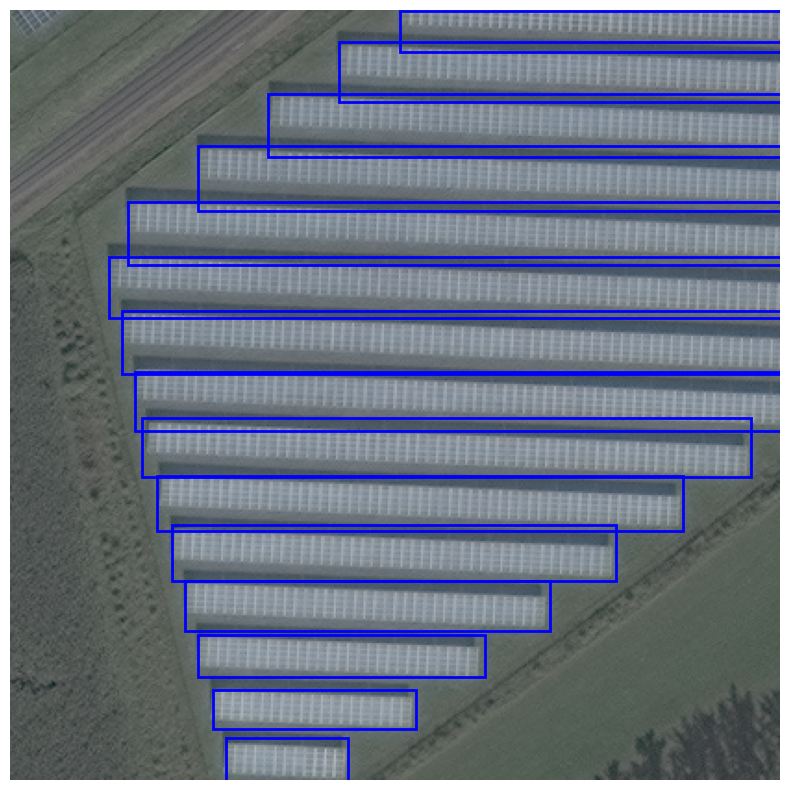

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import json

# Defined a function to visualize the image with annotations
def visualize_image_with_annotations(image_path, annotation_path):
    # Loading the image
    image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Loading the annotations from the JSON file
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    print("Loaded JSON keys:", data.keys())
    # annotations for the specific image
    image_name = os.path.basename(image_path)  # the image file name
    image_id = next((img['id'] for img in data['images'] if img['file_name'] == image_name), None)

    if image_id is not None:
        annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
        print("Found image ID:", image_id)
        print("Number of annotations found:", len(annotations))

        # Iterate through annotations and draw bounding boxes
        for annotation in annotations:
            x, y, w, h = annotation['bbox']

            # Draw the bounding box
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none'))

    # Show the image with annotations
    plt.axis('off')
    plt.show()

# Example to visualize a sample image and annotation
image_path = '/content/drive/MyDrive/image_chips_native/solarpanels_native_3__x0_10977_y0_9825_dxdy_416.tif'
annotation_path = '/content/drive/MyDrive/image_chips_native/solar_panel_coco_annotations.json'

visualize_image_with_annotations(image_path, annotation_path)

# Training the Model

In [ ]:
!pip install ultralytics==8.0.196
!pip install supervision==0.18.0
!pip install opencv-python==4.8.1.78
!pip install matplotlib==3.7.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 857.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 89.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
^C


In [ ]:
import os
import shutil
from pathlib import Path

def organize_dataset():
    # Base paths
    source_image_dir = '/content/drive/MyDrive/image_chips_native'
    dataset_base = '/content/dataset'

    # Count and verify label files
    train_labels = list(Path(f'{dataset_base}/train/labels').glob('*.txt'))
    val_labels = list(Path(f'{dataset_base}/val/labels').glob('*.txt'))
    test_labels = list(Path(f'{dataset_base}/test/labels').glob('*.txt'))

    print(f"Found {len(train_labels)} train, {len(val_labels)} val, and {len(test_labels)} test label files")

    # Function to copy corresponding images
    def copy_images_for_labels(label_files, target_dir):
        copied = 0
        for label_path in label_files:
            image_name = label_path.stem + '.jpg'
            source_image = Path(source_image_dir) / image_name

            # Check multiple possible extensions if .jpg doesn't exist
            if not source_image.exists():
                for ext in ['.jpeg', '.png', '.tif', '.tiff']:
                    alt_source = Path(source_image_dir) / (label_path.stem + ext)
                    if alt_source.exists():
                        source_image = alt_source
                        break

            if source_image.exists():
                shutil.copy2(source_image, target_dir / image_name)
                copied += 1
            else:
                print(f"Warning: No image found for label {label_path.name}")

        return copied

    # Creating image directories if they don't exist
    for split in ['train', 'val', 'test']:
        os.makedirs(f'{dataset_base}/{split}/images', exist_ok=True)

    # Copying images to respective directories
    train_copied = copy_images_for_labels(train_labels, Path(f'{dataset_base}/train/images'))
    val_copied = copy_images_for_labels(val_labels, Path(f'{dataset_base}/val/images'))
    test_copied = copy_images_for_labels(test_labels, Path(f'{dataset_base}/test/images'))

    print(f"\nCopied {train_copied} training images")
    print(f"Copied {val_copied} validation images")
    print(f"Copied {test_copied} test images")

    return train_copied > 0 and val_copied > 0 and test_copied > 0

if __name__ == "__main__":
    success = organize_dataset()
    if success:
        print("\nDataset organization completed successfully")
    else:
        print("\nError: Failed to organize dataset properly")

Found 1842 train, 205 val, and 512 test label files

Copied 1839 training images
Copied 204 validation images
Copied 510 test images

Dataset organization completed successfully


In [ ]:
import yaml

data_config = {
    'path': '/content/dataset',  # Root directory
    'train': 'train/images',     # 1839 images
    'val': 'val/images',         # 204 images
    'test': 'test/images',       # 510 images

    'names': {
        0: 'solar_panel'
    },
    'nc': 1
}

with open('solar_panel_dataset.yaml', 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

In [ ]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import supervision as sv
from supervision.draw.color import ColorPalette
import cv2
import numpy as np
from supervision.metrics.detection import (
    MeanAveragePrecision,
    ConfusionMatrix
)
import logging
from datetime import datetime

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def train_model():
    logger.info("Initializing training process...")

    # Initialize model
    model = YOLO('yolov8n.pt')
    logger.info("Model initialized successfully")

    # Start time
    start_time = datetime.now()

    try:
        # Train the model
        results = model.train(
            data='solar_panel_dataset.yaml',
            epochs=10,
            imgsz=640,
            batch=16,
            patience=10,
            save=True,
            device='cpu',
            verbose=True,
            save_period=5,
            plots=True
        )

        training_duration = datetime.now() - start_time
        logger.info(f"Training completed in {training_duration}")

        # Save training plots
        logger.info("Generating training visualization...")
        plt.figure(figsize=(15, 10))
        results.plot()
        plt.savefig('training_results.png')
        plt.close()

        return model, results

    except Exception as e:
        logger.error(f"Error during training: {str(e)}")
        raise

def evaluate_model(model, test_path='/content/dataset/test/images'):
    logger.info("Starting model evaluation...")

    # Perform validation on test set
    metrics = model.val(data='solar_panel_dataset.yaml', split='test')

    # Log evaluation results
    logger.info(f"Model Performance Metrics:")
    logger.info(f"mAP50: {metrics.box.map50:.4f}")
    logger.info(f"mAP50-95: {metrics.box.map:.4f}")
    logger.info(f"Precision: {metrics.box.p:.4f}")
    logger.info(f"Recall: {metrics.box.r:.4f}")

    return metrics

if __name__ == "__main__":
    logger.info("Starting solar panel detection model training...")

    # Train model
    model, results = train_model()

    # Evaluate model
    metrics = evaluate_model(model)

    logger.info("Training and evaluation completed successfully")

New https://pypi.org/project/ultralytics/8.3.76 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=solar_panel_dataset.yaml, epochs=10, patience=10, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_n

lr/pg0,▂▆█▇▇▆▅▃▂▁
lr/pg1,▂▆█▇▇▆▅▃▂▁
lr/pg2,▂▆█▇▇▆▅▃▂▁
metrics/mAP50(B),▁▂▄▅▆▇▇███
metrics/mAP50-95(B),▁▂▃▅▆▆▆▇██
metrics/precision(B),▂▁▂▄▅▆▆▇██
metrics/recall(B),▁▄▅▆▆▆▇▇██
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▄▄▃▃▂▂▁


ERROR:__main__:Error during training: 'bool' object is not callable


TypeError: 'bool' object is not callable

<Figure size 1500x1000 with 0 Axes>

In [ ]:
ls runs/detect/train/


args.yaml                                            labels.jpg        train_batch2.jpg
events.out.tfevents.1739966797.ff2bb0ab5e9e.17114.0  train_batch0.jpg  weights/
labels_correlogram.jpg                               train_batch1.jpg
